<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/MCSO/notebooks/12_BikeSharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Forecasting with Recurrent Neural Network (RNN)

En este ejemplo se probará con RNN pero podríamos utilizar otra red como LSTM

Os invito a probar y comparar

### Abstract

* Purpose: to practice solving a timeseries problem by using Recurrent Neural Network

* Data: Bike Sharing in Washington D.C. Dataset

* Applied Tools & Methods: TimeSeriesGenerator, SimpleRNN

* Result: Around %80 correctness (calculated as 1-mae/mean)

* Further Studies: More advanced sequential methods like LSTM and GRU can be applied.

### Explanation of the Study

We have created a model to predict how many bicycles will be rented in the following days. The features used like weather, temperature, working day are explained in the following sections in detail. 

We have used SimpleRNN method in Keras library. It is one of the sequential models. The others are LSTM and GRU. 

Sequential models have 3 dimension (sample size, time steps, features). Preparing 3D input is another challenge. Instead of trying to create a 3D array, we use TimeSeriesGenerator class which brings some other advantages like setting the batch size.

We skipped feature engineering and visualization parts because main purpose was to practice a sequential neural network. It is possible to have better achivements by applying these methods and then create a predictive model. 

Data is 2 years daily data. Number of samples is 731. We have splitted it into 631, 50, 50 as train, test and hold-out data respectively.

We have measured the performance of the model with ( 1 - (mean average error) / (mean) ) and we have reached values around %80.

There are so many further studies: More feature engineering for better accuracy and trying other sequential models. 

### Importing Libraries

In [ ]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

### Data Preprocessing

#### Reading the dataset

In [ ]:
dataset = pd.read_csv('day.csv')

In [ ]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
dataset.shape

(731, 16)

Daily data has the following fields. Thanks to the people who prepared it because it is very well processed data with even scaled features. 

instant: Record index

dteday: Date

season: Season (1:springer, 2:summer, 3:fall, 4:winter)

yr: Year (0: 2011, 1:2012)

mnth: Month (1 to 12)

holiday: weather day is holiday or not (extracted from Holiday Schedule)

weekday: Day of the week

workingday: If day is neither weekend nor holiday is 1, otherwise is 0.

weathersit: (extracted from Freemeteo)
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

casual: count of casual users

registered: count of registered users

cnt: count of total rental bikes including both casual and registered

#### Plot of 2 years number of sharing (cnt)

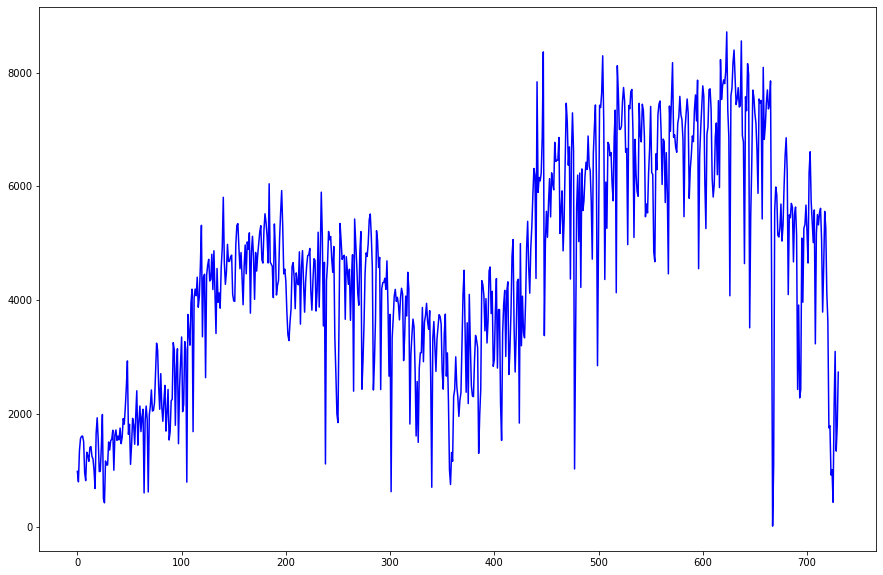

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(dataset['cnt'], color='blue')
plt.show()

#### Data exploration and Manipulation

* Number of bike sharing is 22 only at 2012-10-29 and such a low value deserves a special attention.

* There was a hurricane at Washington at that day.

* Since it is such an extraordinary day, hurricane and the following days data will be replaced by the average of that month.


Lo dicho, hay que ver que pasa exactamente con esos dos días de huracán

In [ ]:
temp = dataset[dataset.yr == 1]   # la serie empieza en 2011 (.yr=0 )
temp = temp[temp.mnth == 10]
print(temp.cnt.mean())

6414.225806451613


In [ ]:
# podemos ver los dos últimos días 667 y 668
temp.head(30)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
639,640,2012-10-01,4,1,10,0,1,1,2,0.520833,0.512000,0.649167,0.090804,763,6015,6778
640,641,2012-10-02,4,1,10,0,2,1,3,0.590833,0.542333,0.871667,0.104475,315,4324,4639
641,642,2012-10-03,4,1,10,0,3,1,2,0.657500,0.599133,0.793750,0.066546,728,6844,7572
642,643,2012-10-04,4,1,10,0,4,1,2,0.657500,0.607975,0.722917,0.117546,891,6437,7328
643,644,2012-10-05,4,1,10,0,5,1,1,0.615000,0.580187,0.627500,0.106350,1516,6640,8156
644,645,2012-10-06,4,1,10,0,6,0,1,0.554167,0.538521,0.664167,0.268025,3031,4934,7965
645,646,2012-10-07,4,1,10,0,0,0,2,0.415833,0.419813,0.708333,0.141162,781,2729,3510
646,647,2012-10-08,4,1,10,1,1,0,2,0.383333,0.387608,0.709583,0.189679,874,4604,5478
647,648,2012-10-09,4,1,10,0,2,1,2,0.446667,0.438112,0.761667,0.190300,601,5791,6392
648,649,2012-10-10,4,1,10,0,3,1,1,0.514167,0.503142,0.630833,0.187821,780,6911,7691


In [ ]:
print(dataset['cnt'][667], dataset['cnt'][668])

22 1096


In [ ]:
# comprobamos los valores de 667 y 668
dataset.loc[667]

instant              668
dteday        2012-10-29
season                 4
yr                     1
mnth                  10
holiday                0
weekday                1
workingday             1
weathersit             3
temp                0.44
atemp             0.4394
hum                 0.88
windspeed         0.3582
casual                 2
registered            20
cnt                   22
Name: 667, dtype: object

In [ ]:
# los reemplazamos por valores medios
dataset['cnt'][667] = 6414
dataset['cnt'][668] = 6414

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# comprobaoms el nuevo valor
print(dataset['cnt'][667], dataset['cnt'][668])

6414 6414


#### One Hot Encoding
Nos permite crear un vector a partir de una variable

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

de manera similar se puede hacer con pandas.get_dummies

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

que convierte series en códigos ficticios

We should apply one hot encoding for categorical features. In our case weekday, weathersit and mnth features are one hot encoded.

In [ ]:


one_hot = pd.get_dummies(dataset['weekday'], prefix='weekday')
dataset = dataset.join(one_hot)

In [ ]:
one_hot = pd.get_dummies(dataset['weathersit'], prefix='weathersit')
dataset = dataset.join(one_hot)

In [ ]:
one_hot = pd.get_dummies(dataset['mnth'], prefix='mnth')
dataset = dataset.join(one_hot)

In [ ]:
# es interesante que vayamos viendo como se van incrementando nuestras variables después de estas intrucciones en nuestro dataset
one_hot.head

<bound method NDFrame.head of      weekday_0  weekday_1  weekday_2  ...  weekday_4  weekday_5  weekday_6
0            0          0          0  ...          0          0          1
1            1          0          0  ...          0          0          0
2            0          1          0  ...          0          0          0
3            0          0          1  ...          0          0          0
4            0          0          0  ...          0          0          0
..         ...        ...        ...  ...        ...        ...        ...
726          0          0          0  ...          1          0          0
727          0          0          0  ...          0          1          0
728          0          0          0  ...          0          0          1
729          1          0          0  ...          0          0          0
730          0          1          0  ...          0          0          0

[731 rows x 7 columns]>

In [ ]:
dataset.head
dataset.shape

(731, 39)

#### Scaling

Thanks to the guys prepared the original data, they scaled all features. That is why we have to apply it only for our value Y which is cnt. It is also a discussion whether Y value should be scaled or not in sucha model but we did. 

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['cnt']).reshape(len(dataset['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

In [ ]:
dataset = pd.merge(dataset, series, left_index=True, right_index=True)

In [ ]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.066884
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.044670
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.110829
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.136545
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.141132


#### Data Splitting

In [ ]:
number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 631 50 50


In [ ]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

The following steps show the way how to prepare input for a sequential model by using TimeSeriesGenerator.

Clase para generar lotes de datos temporales.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

In [ ]:
in_seq1 = array(datatrain['holiday'])
in_seq2 = array(datatrain['workingday'])
in_seq3 = array(datatrain['temp'])
in_seq4 = array(datatrain['atemp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [ ]:
in_seq1.shape # datos de entrada de entrenamiento

(631,)

In [ ]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [ ]:
in_seq1.shape

(631, 1)

In [ ]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [ ]:
datatrain_feed.shape

(631, 17)

ahora hacemos lo mismo para el test

In [ ]:
in_seq1 = array(datatest['holiday'])
in_seq2 = array(datatest['workingday'])
in_seq3 = array(datatest['temp'])
in_seq4 = array(datatest['atemp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [ ]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [ ]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [ ]:
datatest_feed.shape

(50, 17)

In [ ]:
in_seq1 = array(datahold['holiday'])
in_seq2 = array(datahold['workingday'])
in_seq3 = array(datahold['temp'])
in_seq4 = array(datahold['atemp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [ ]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [ ]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [ ]:
datahold_feed.shape

(50, 17)

Pequeño ejemplo para ver cómo se generan las secuencias de TimeseriesGenerator

https://pypi.org/project/time-series-generator/

In [ ]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [ ]:
generator_train[0]

In [ ]:
for i in range(len(generator_train)):
	x, y = generator_train[i]
	print('%s => %s' % (x, y))

[[[0.         0.         0.344167   ... 1.         0.         0.06688398]
  [0.         0.         0.363478   ... 1.         0.         0.04466981]
  [0.         1.         0.196364   ... 0.         0.         0.11082941]
  ...
  [0.         0.         0.165      ... 1.         0.         0.06374502]
  [0.         0.         0.138333   ... 0.         0.         0.04720512]
  [0.         1.         0.150833   ... 0.         0.         0.10744899]]

 [[0.         0.         0.363478   ... 1.         0.         0.04466981]
  [0.         1.         0.196364   ... 0.         0.         0.11082941]
  [0.         1.         0.2        ... 0.         0.         0.13654473]
  ...
  [0.         0.         0.138333   ... 0.         0.         0.04720512]
  [0.         1.         0.150833   ... 0.         0.         0.10744899]
  [0.         1.         0.169091   ... 1.         0.         0.1004467 ]]

 [[0.         1.         0.196364   ... 0.         0.         0.11082941]
  [0.         1.      

In [ ]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [ ]:
for i in range(len(generator_test)):
	x, y = generator_test[i]
	print('%s => %s' % (x, y))

[[[0.         0.         0.529167   0.518933   0.467083   0.223258
   1.         0.         0.         0.         0.         0.
   0.         1.         0.         0.         0.90257153]
  [0.         1.         0.514167   0.502513   0.492917   0.142404
   0.         1.         0.         0.         0.         0.
   0.         1.         0.         0.         0.84570808]
  [0.         1.         0.55       0.544179   0.57       0.236321
   0.         0.         1.         0.         0.         0.
   0.         1.         0.         0.         0.85802246]
  [0.         1.         0.635      0.596613   0.630833   0.2444
   0.         0.         0.         1.         0.         0.
   0.         1.         0.         0.         0.88156465]
  [0.         1.         0.65       0.607975   0.690833   0.134342
   0.         0.         0.         0.         1.         0.
   0.         0.         1.         0.         0.84051672]
  [0.         1.         0.619167   0.585863   0.69       0.164179


In [ ]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

In [ ]:
for i in range(len(generator_hold)):
	x, y = generator_hold[i]
	print('%s => %s' % (x, y))

[[[1.         0.         0.485      0.475383   0.741667   0.173517
   0.         1.         0.         0.         0.         0.
   0.         1.         0.         0.         0.7048171 ]
  [0.         1.         0.343333   0.323225   0.662917   0.342046
   0.         0.         1.         0.         0.         0.
   0.         0.         1.         0.         0.44223108]
  [0.         1.         0.289167   0.281563   0.552083   0.199625
   0.         0.         0.         1.         0.         0.
   0.         1.         0.         0.         0.61137269]
  [0.         1.         0.321667   0.324492   0.620417   0.152987
   0.         0.         0.         0.         1.         0.
   0.         0.         1.         0.         0.60533623]
  [0.         1.         0.345      0.347204   0.524583   0.171025
   0.         0.         0.         0.         0.         1.
   0.         1.         0.         0.         0.63588072]
  [0.         0.         0.325      0.326383   0.545417   0.17972

# **Preprocesamiento de datos**

Como siempre el preprocesamiento de datos es lo que más tiempo nos lleva

Ahora realmente empezaríamos con la creación del modelo

### Modelling and Training

We have created a small RNN with 4 nodes. 
Number of total parameters in the model is 93. 
Number of timesteps in one batch is 10. 
Activation function is relu both for RNN and Output layer.
Optimizer is adam.
Loss function is mean squared error.
Learning rate is 0.0001.
Number of epocs is 3,000.

#### Creating the SimpleRNN Model

In [ ]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 17


Sencillo modelo de RNN

In [ ]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [ ]:
score = model.fit_generator(generator_train, epochs=3000, verbose=2, validation_data=generator_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Streaming output truncated to the last 5000 lines.
Epoch 501/3000
1/1 - 0s - loss: 0.1012 - val_loss: 0.2113
Epoch 502/3000
1/1 - 0s - loss: 0.1011 - val_loss: 0.2111
Epoch 503/3000
1/1 - 0s - loss: 0.1010 - val_loss: 0.2109
Epoch 504/3000
1/1 - 0s - loss: 0.1009 - val_loss: 0.2108
Epoch 505/3000
1/1 - 0s - loss: 0.1008 - val_loss: 0.2106
Epoch 506/3000
1/1 - 0s - loss: 0.1007 - val_loss: 0.2104
Epoch 507/3000
1/1 - 0s - loss: 0.1005 - val_loss: 0.2103
Epoch 508/3000
1/1 - 0s - loss: 0.1004 - val_loss: 0.2101
Epoch 509/3000
1/1 - 0s - loss: 0.1003 - val_loss: 0.2099
Epoch 510/3000
1/1 - 0s - loss: 0.1002 - val_loss: 0.2097
Epoch 511/3000
1/1 - 0s - loss: 0.1001 - val_loss: 0.2096
Epoch 512/3000
1/1 - 0s - loss: 0.1000 - val_loss: 0.2094
Epoch 513/3000
1/1 - 0s - loss: 0.0999 - val_loss: 0.2092
Epoch 514/3000
1/1 - 0s - loss: 0.0998 - val_loss: 0.2090
Epoch 515/3000
1/1 - 0s - loss: 0.0997 - val_loss: 0.2088
Epoch 516/3000
1/1 - 0s - loss: 0.0996 - val_loss: 0.2087
Epoch 517/3000
1/1 - 

#### Plot of Training and Test Loss Functions

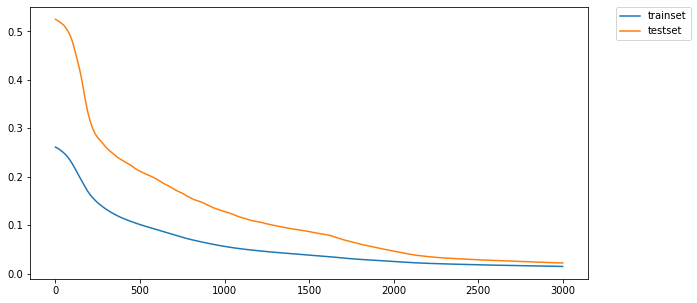

In [ ]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Predictions for Test Data

#### Predicting for Test Data

In [ ]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


#### Tabulating Actuals, Predictions and Differences

In [ ]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [ ]:
df_result

,Actual,Prediction,Diff
0,7572.0,6571.895996,-13.207924
1,7328.0,6338.710938,-13.500124
2,8156.0,7331.697754,-10.106697
3,7965.0,6049.545898,-24.048388
4,3510.0,7111.142578,102.596655
5,5478.0,6075.660645,10.910198
6,6392.0,7448.794922,16.533087
7,7691.0,6410.654785,-16.647318
8,7570.0,6360.716797,-15.974679
9,7282.0,6923.351074,-4.925143


#### Calculating the Correctness for Test Data

In [ ]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  6547.175
mae: 943.79599609375
mae/mean ratio:  14.415316469985147 %
correctness:  85.58468353001486 %


#### Plot of Actuals and Predictions for Test Data

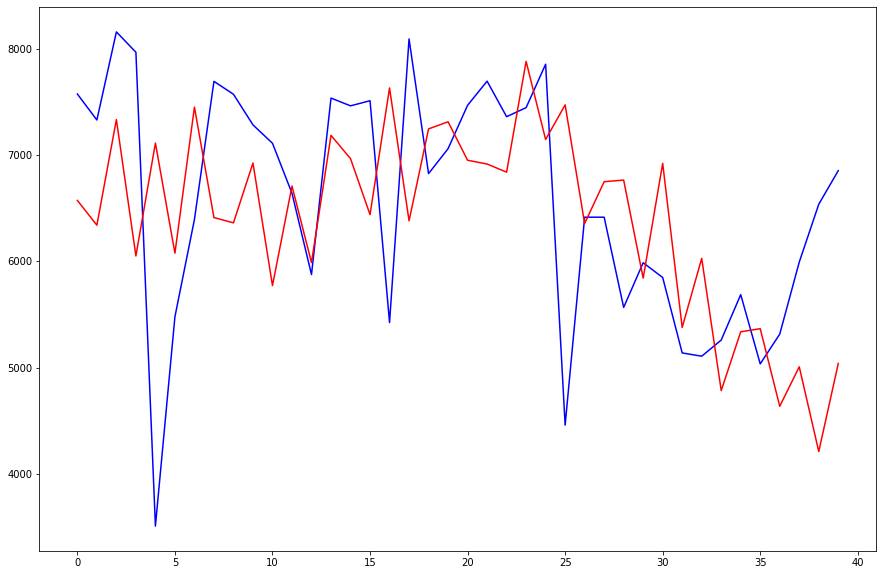

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### Predictions for Hold-Out Data

#### Predicting for Hold-Out Data

In [ ]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


#### Tabulating Actuals, Predictions and Differences for Hold-Out Data

In [ ]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [ ]:
df_result

,Actual,Prediction,Diff
0,2425.0,5242.080566,116.168271
1,3910.0,5712.058105,46.088443
2,2277.0,4513.355469,98.214996
3,2424.0,4735.193848,95.346281
4,5087.0,4637.183594,-8.842469
5,3959.0,4548.484375,14.889729
6,5260.0,4381.722656,-16.697288
7,5323.0,4235.456543,-20.431025
8,5668.0,4603.021484,-18.789317
9,5191.0,3890.012939,-25.062359


#### Calculating the Correctness for Hold-Out Data

In [ ]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  4001.15
mae: 1292.7729888916015
mae/mean ratio:  32.310035587058756 %
correctness:  67.68996441294124 %


#### Plot of Actuals and Predictions for Hold-Out Data

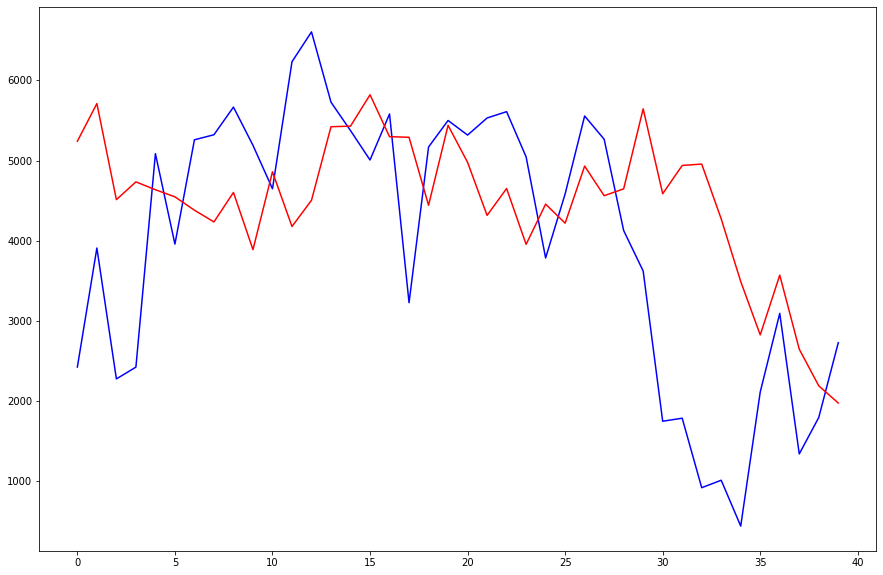

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()